Loading break_data...
Income knot (ibar): 9.0870
CDD means by tpid:  {1.0: 2412.935302734375, 2.0: 1115.5257568359375, 3.0: 223.83599853515625}
HDD means by tpid:  {1.0: 156.36099243164062, 2.0: 1178.0726318359375, 3.0: 3925.803955078125}
Inc means by tgpid: {1.0: 7.4978461265563965, 2.0: 8.77016830444336, 3.0: 9.997271537780762}

LOADING NEW DATA
  GMFD: 61 coefficients
  ERA5: 61 coefficients
  JRA_3Q: 61 coefficients
  MERRA2: 61 coefficients

LOADING ORIGINAL DATA
  Original: 57 coefficients, suffix='_GMFD'
  Sanity check b_cdd (k=1, pg=1): 3.577117e-07
  Sanity check b_cdd new GMFD (k=1, pg=1): 1.649048e-06

Plotting new data...
Saved: NEW_all_products_electricity_TINV_clim_quadinter.pdf

Plotting original data...
Saved: ORIGINAL_electricity_TINV_clim_quadinter.pdf

Plotting comparison...
Saved: COMPARISON_GMFD_electricity_TINV_clim_quadinter.pdf

ALL DONE
Figures saved to: /user/ab5405/summeraliaclimate/code/energy_uncertainty/figures/comparison


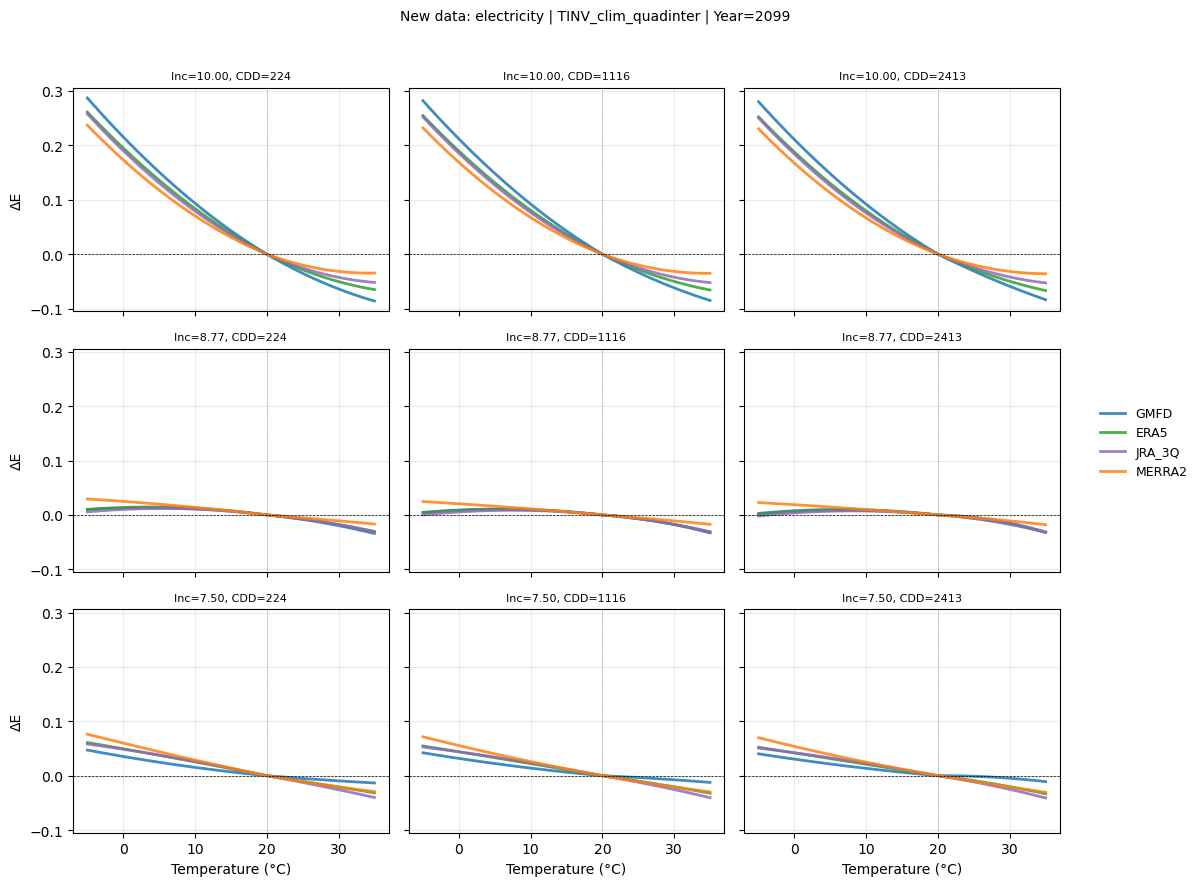

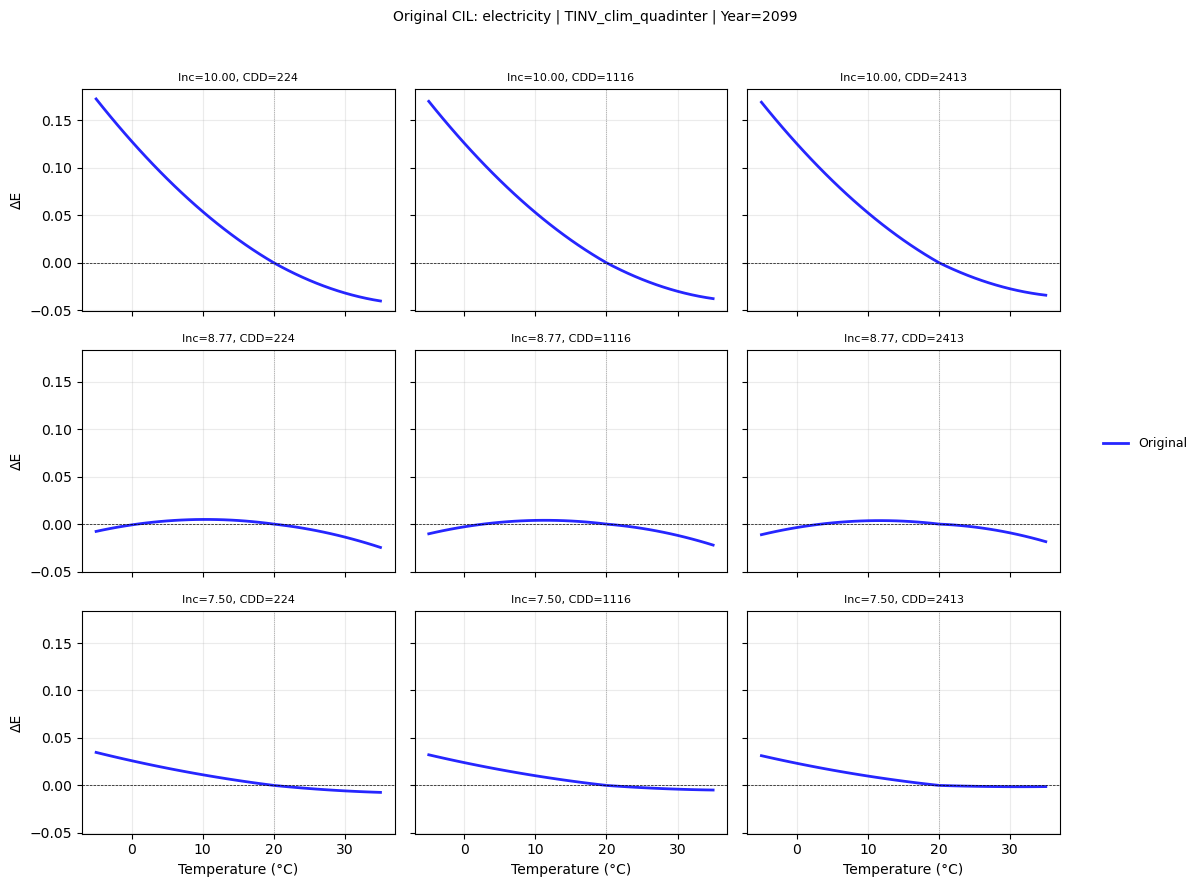

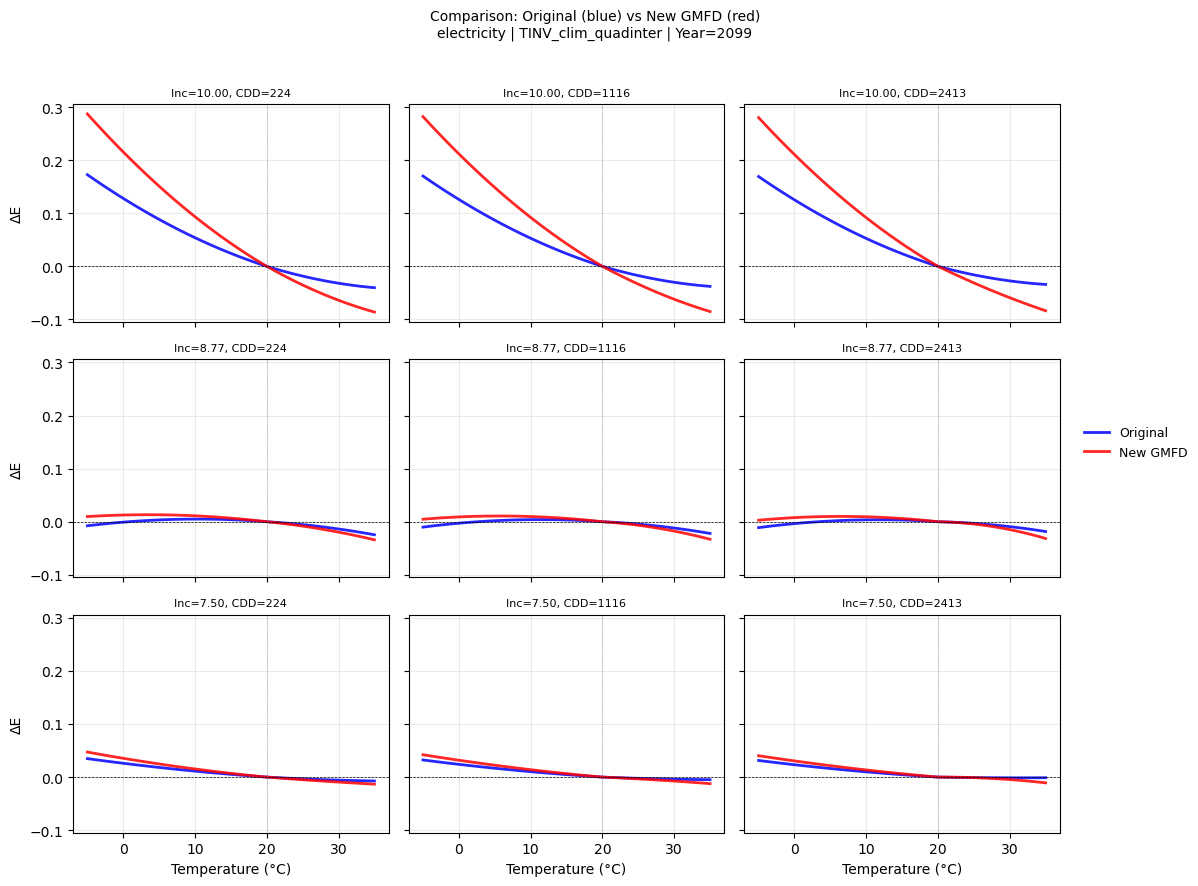

In [13]:
"""
plot_energy_response.py

Plots the energy-temperature response function from the Rode et al. (2021)
interacted FD specification (quadinter), estimated across four observational
climate products (GMFD, ERA5, JRA-3Q, MERRA2).

Replicates Figure 1C: a 3x3 matrix of income tercile (rows, increasing
bottom to top) x climate tercile based on CDD (columns, increasing
left to right). Point estimates only — no MC bands.

Produces three figures:
  1. New data: all four products overlaid in each cell.
  2. Original CIL data: single curve per cell.
  3. Comparison: original (blue) vs new GMFD (red).

Inputs
------
- NEW_STER / FD_FGLS_inter_{MODEL_NAME}_{product}_coeff.csv
- ORIG_STER / FD_FGLS_inter_{MODEL_NAME}_coeff.csv
- BREAK_DATA: break_data_TINV_clim.dta
"""

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# ============================================================
# PATHS
# ============================================================
EU  = Path("/user/ab5405/summeraliaclimate/code/energy_uncertainty")
EDR = Path("/user/ab5405/summeraliaclimate/code/energy_consumption/"
           "energy_data_release_2021oct21")

NEW_STER   = EU / "data" / "regression" / "sters"
ORIG_STER  = EU / "output_original" / "sters"
BREAK_DATA = EDR / "DATA" / "regression" / "break_data_TINV_clim.dta"

OUTDIR = EU / "figures" / "comparison"
OUTDIR.mkdir(parents=True, exist_ok=True)

# ============================================================
# SETTINGS
# ============================================================
FUEL       = "electricity"         # "electricity" or "other_energy"
YEAR_PLOT  = 2099                  # year at which to evaluate temp×year terms
MODEL_NAME = "TINV_clim_quadinter" # must match Stata local model_name

# Temperature grid: -5 to 35°C, matching original Stata plot
T       = np.arange(-5, 36, 1.0)
ABOVE20 = (T >= 20).astype(float)
BELOW20 = (T  < 20).astype(float)

# Colors for the four new-pipeline products
PROD_COLORS = {
    "GMFD":   "#1f77b4",
    "ERA5":   "#2ca02c",
    "JRA_3Q": "#9467bd",
    "MERRA2": "#ff7f0e",
}

# ============================================================
# I/O HELPERS
# ============================================================

def read_coeff_csv(path: Path) -> pd.Series:
    """
    Read coefficient CSV (parm, beta) exported from Stata.
    Strips whitespace from names — Stata sometimes pads them.
    """
    df = pd.read_csv(path)
    df["parm"] = df["parm"].str.strip()
    return pd.Series(df["beta"].values, index=df["parm"].values)


def get_coeff(coef: pd.Series, name: str, default: float = 0.0) -> float:
    """
    Look up a coefficient by name. Returns 0.0 if not found — correct
    for omitted/collinear terms. Print coef.index if curves look wrong.
    """
    return float(coef[name]) if name in coef.index else float(default)


def ibar_from_breakdata(bd: pd.DataFrame, fuel: str) -> float:
    """
    Income spline knot: maximum log income of large income group 1.
    The dc1 spline term is lgdppc_MA15 - ibar.
    """
    return float(
        bd.loc[bd[f"largegpid_{fuel}"] == 1, f"maxInc_largegpid_{fuel}"].max()
    )


def get_tercile_means(bd: pd.DataFrame) -> tuple[dict, dict, dict]:
    """
    Population-weighted tercile means from break_data.
    tpid: 1=coldest, 3=hottest. tgpid: 1=lowest income, 3=highest.

    The original Stata script indexes climate covariates as:
        local tr_index = tr * 3
        local subCDD = avgCDD_tpid[tr_index]
    after sorting tpid tgpid and dropping duplicates. This groupby
    mean is equivalent when there is one unique value per tpid.
    """
    cdd_means = bd.groupby("tpid")["avgCDD_tpid"].mean().to_dict()
    hdd_means = bd.groupby("tpid")["avgHDD_tpid"].mean().to_dict()
    inc_means = bd.groupby("tgpid")["avgInc_tgpid"].mean().to_dict()
    return cdd_means, hdd_means, inc_means


# ============================================================
# RESPONSE FUNCTION
# ============================================================

def yhat_interacted(
    coef:   pd.Series,
    fuel:   str,
    subInc: float,
    subCDD: float,
    subHDD: float,
    ibar:   float,
    year:   int,
    suffix: str = "",
    max_k:  int = 2,
) -> np.ndarray:
    """
    Evaluate the interacted energy response curve for a covariate cell.

    Matches the original Stata predictnl expression (Figure 1C):

    For k = 1, 2:
        y += b_temp  * (T^k - 20^k)
           + above20 * b_cdd * subCDD * (T^k - 20^k)
           + below20 * b_hdd * subHDD * (20^k - T^k)
           + b_dc1   * deltacut * (T^k - 20^k)
           + b_yt    * year * (T^k - 20^k)           [lininter/quadinter]
           + b_dc1y  * deltacut * year * (T^k - 20^k)
           + b_y2t   * year^2 * (T^k - 20^k)         [quadinter only]
           + b_dc1y2 * deltacut * year^2 * (T^k - 20^k)

    All terms normalized to 0 at T=20°C.

    Parameters
    ----------
    suffix : "" for new pipeline, "_GMFD" for original CIL release
    max_k  : 2 matches original plotting script (k=1..2 only)
    """
    pg       = 1 if fuel == "electricity" else 2
    ig       = 2 if subInc > ibar else 1
    deltacut = subInc - ibar

    y = np.zeros_like(T, dtype=float)

    for k in range(1, max_k + 1):
        Tk       = T ** k
        dT       = Tk - (20.0 ** k)
        dT_below = (20.0 ** k) - Tk

        b_temp   = get_coeff(coef, f"c.indp{pg}#c.indf1#c.FD_temp{k}{suffix}")
        b_cdd    = get_coeff(coef, f"c.indp{pg}#c.indf1#c.FD_cdd20_TINVtemp{k}{suffix}")
        b_hdd    = get_coeff(coef, f"c.indp{pg}#c.indf1#c.FD_hdd20_TINVtemp{k}{suffix}")
        b_dc1    = get_coeff(coef, f"c.indp{pg}#c.indf1#c.FD_dc1_lgdppc_MA15I{ig}temp{k}")
        b_yt     = get_coeff(coef, f"c.indp{pg}#c.indf1#c.FD_yeartemp{k}{suffix}")
        b_dc1y   = get_coeff(coef, f"c.indp{pg}#c.indf1#c.FD_dc1_lgdppc_MA15yearI{ig}temp{k}")
        b_y2t    = get_coeff(coef, f"c.indp{pg}#c.indf1#c.FD_year2temp{k}{suffix}")
        b_dc1y2  = get_coeff(coef, f"c.indp{pg}#c.indf1#c.FD_dc1_lgdppc_MA15year2I{ig}temp{k}")

        y += b_temp  * dT
        y += ABOVE20 * b_cdd   * subCDD        * dT
        y += BELOW20 * b_hdd   * subHDD        * dT_below
        y += b_dc1   * deltacut                * dT
        y += b_yt    * year                    * dT
        y += b_dc1y  * deltacut * year         * dT
        y += b_y2t   * (year ** 2)             * dT
        y += b_dc1y2 * deltacut * (year ** 2)  * dT

    return y


# ============================================================
# PLOTTING HELPER
# ============================================================

def plot_3x3(
    coef_dict:   dict,
    suffix_dict: dict,
    color_dict:  dict,
    title:       str,
) -> plt.Figure:
    """
    Draw a 3x3 income x climate panel, overlaying all entries in coef_dict.

    Layout matches original Figure 1C:
      Rows: income tercile, high (top) to low (bottom)  — lg = 3, 2, 1
      Cols: climate tercile by CDD, warm (left) to cold (right) — tr = 3, 2, 1

    Note: the original Stata figure has cold on the LEFT and warm on the
    RIGHT (forval tr=3(-1)1 with tr=3 being hottest). The column titles
    will confirm the ordering via their CDD values.
    """
    fig, axes = plt.subplots(3, 3, figsize=(12, 9), sharex=True, sharey=True)
    fig.suptitle(title, y=0.98, fontsize=10)

    legend_handles = []
    legend_labels  = []

    for r, lg in enumerate([3, 2, 1]):
        for c, tr in enumerate([3, 2, 1]):
            ax     = axes[r, c]
            subInc = inc_means[lg]
            subCDD = cdd_means[tr]
            subHDD = hdd_means[tr]

            for label, coef in coef_dict.items():
                suffix = suffix_dict.get(label, "")
                color  = color_dict.get(label, "black")

                y = yhat_interacted(
                    coef, FUEL, subInc, subCDD, subHDD,
                    ibar, YEAR_PLOT, suffix=suffix
                )
                ln, = ax.plot(T, y, linewidth=2, color=color, alpha=0.85)

                if r == 0 and c == 0 and label not in legend_labels:
                    legend_handles.append(ln)
                    legend_labels.append(label)

            ax.axhline(0,  color="black", linewidth=0.5, linestyle="--")
            ax.axvline(20, color="gray",  linewidth=0.5, linestyle=":")
            ax.set_title(f"Inc={subInc:.2f}, CDD={subCDD:.0f}", fontsize=8)
            ax.grid(True, alpha=0.25)

            if c == 0:
                ax.set_ylabel("ΔE", fontsize=10)
            if r == 2:
                ax.set_xlabel("Temperature (°C)", fontsize=10)

    if legend_handles:
        fig.legend(legend_handles, legend_labels,
                   loc="center right", frameon=False, fontsize=9)
        plt.tight_layout(rect=[0, 0, 0.90, 0.96])
    else:
        plt.tight_layout(rect=[0, 0, 1, 0.96])

    return fig


# ============================================================
# LOAD BREAK DATA
# ============================================================
print("Loading break_data...")
bd = pd.read_stata(BREAK_DATA)

ibar                            = ibar_from_breakdata(bd, FUEL)
cdd_means, hdd_means, inc_means = get_tercile_means(bd)

print(f"Income knot (ibar): {ibar:.4f}")
print(f"CDD means by tpid:  {cdd_means}")
print(f"HDD means by tpid:  {hdd_means}")
print(f"Inc means by tgpid: {inc_means}")

# ============================================================
# LOAD COEFFICIENTS
# ============================================================
print("\n" + "=" * 60)
print("LOADING NEW DATA")
print("=" * 60)

products_new = ["GMFD", "ERA5", "JRA_3Q", "MERRA2"]
coefs_new = {}

for prod in products_new:
    path = NEW_STER / f"FD_FGLS_inter_{MODEL_NAME}_{prod}_coeff.csv"
    if path.exists():
        coefs_new[prod] = read_coeff_csv(path)
        print(f"  {prod}: {len(coefs_new[prod])} coefficients")
    else:
        print(f"  WARNING: {path.name} not found")

print("\n" + "=" * 60)
print("LOADING ORIGINAL DATA")
print("=" * 60)

coef_orig   = None
suffix_orig = ""

orig_path = ORIG_STER / f"FD_FGLS_inter_{MODEL_NAME}_coeff.csv"
if orig_path.exists():
    coef_orig   = read_coeff_csv(orig_path)
    has_suffix  = any("_GMFD" in n for n in coef_orig.index)
    suffix_orig = "_GMFD" if has_suffix else ""
    print(f"  Original: {len(coef_orig)} coefficients, suffix={suffix_orig!r}")
else:
    print(f"  WARNING: {orig_path.name} not found")

# Quick sanity check — print a key coefficient so you can verify
# against the Stata output before trusting the plots
if coef_orig is not None:
    key = f"c.indp1#c.indf1#c.FD_cdd20_TINVtemp1{suffix_orig}"
    print(f"  Sanity check b_cdd (k=1, pg=1): {get_coeff(coef_orig, key):.6e}")

if "GMFD" in coefs_new:
    key = "c.indp1#c.indf1#c.FD_cdd20_TINVtemp1"
    print(f"  Sanity check b_cdd new GMFD (k=1, pg=1): {get_coeff(coefs_new['GMFD'], key):.6e}")

# ============================================================
# PLOT 1 — NEW DATA (all four products)
# ============================================================
if coefs_new:
    print("\nPlotting new data...")
    fig1 = plot_3x3(
        coef_dict   = coefs_new,
        suffix_dict = {p: "" for p in products_new},
        color_dict  = PROD_COLORS,
        title       = f"New data: {FUEL} | {MODEL_NAME} | Year={YEAR_PLOT}",
    )
    out1 = OUTDIR / f"NEW_all_products_{FUEL}_{MODEL_NAME}.pdf"
    fig1.savefig(out1)
    print(f"Saved: {out1.name}")

# ============================================================
# PLOT 2 — ORIGINAL DATA
# ============================================================
if coef_orig is not None:
    print("\nPlotting original data...")
    fig2 = plot_3x3(
        coef_dict   = {"Original": coef_orig},
        suffix_dict = {"Original": suffix_orig},
        color_dict  = {"Original": "blue"},
        title       = f"Original CIL: {FUEL} | {MODEL_NAME} | Year={YEAR_PLOT}",
    )
    out2 = OUTDIR / f"ORIGINAL_{FUEL}_{MODEL_NAME}.pdf"
    fig2.savefig(out2)
    print(f"Saved: {out2.name}")

# ============================================================
# PLOT 3 — COMPARISON: original (blue) vs new GMFD (red)
# ============================================================
if "GMFD" in coefs_new and coef_orig is not None:
    print("\nPlotting comparison...")
    fig3 = plot_3x3(
        coef_dict   = {"Original": coef_orig, "New GMFD": coefs_new["GMFD"]},
        suffix_dict = {"Original": suffix_orig, "New GMFD": ""},
        color_dict  = {"Original": "blue", "New GMFD": "red"},
        title       = (f"Comparison: Original (blue) vs New GMFD (red)\n"
                       f"{FUEL} | {MODEL_NAME} | Year={YEAR_PLOT}"),
    )
    out3 = OUTDIR / f"COMPARISON_GMFD_{FUEL}_{MODEL_NAME}.pdf"
    fig3.savefig(out3)
    print(f"Saved: {out3.name}")

print("\n" + "=" * 60)
print("ALL DONE")
print("=" * 60)
print(f"Figures saved to: {OUTDIR}")
plt.show()